In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)

In [287]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [288]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [289]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [290]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [291]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [292]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [293]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [294]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [295]:
DIM = 70

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM

In [296]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
decoded1 = Dense(encoding_dim3, activation='tanh')(encoded4)
decoded2 = Dense(encoding_dim2, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim1, activation='relu')(decoded2)
decoded4 = Dense(xtrain1.shape[1], activation='relu')(decoded3)

autoencoder = Model(inputs, decoded4)
encoder = Model(inputs, encoded4)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [297]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_10 (Dense)             (None, 280)               98280     
_________________________________________________________________
dense_11 (Dense)             (None, 210)               59010     
_________________________________________________________________
dense_12 (Dense)             (None, 70)                14770     
_________________________________________________________________
dense_13 (Dense)             (None, 210)               14910     
_________________________________________________________________
dense_14 (Dense)             (None, 280)               59080     
__________

In [298]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 350)               128100    
_________________________________________________________________
dense_10 (Dense)             (None, 280)               98280     
_________________________________________________________________
dense_11 (Dense)             (None, 210)               59010     
_________________________________________________________________
dense_12 (Dense)             (None, 70)                14770     
Total params: 300,160
Trainable params: 300,160
Non-trainable params: 0
_________________________________________________________________


In [299]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 1s 237us/step - loss: 32.4311 - val_loss: 31.6769
Epoch 2/1000
5000/5000 [==============================] - 1s 131us/step - loss: 31.4624 - val_loss: 31.0541
Epoch 3/1000
5000/5000 [==============================] - 1s 130us/step - loss: 30.8110 - val_loss: 30.4220
Epoch 4/1000
5000/5000 [==============================] - 1s 128us/step - loss: 30.0875 - val_loss: 29.6631
Epoch 5/1000
5000/5000 [==============================] - 1s 131us/step - loss: 29.2155 - val_loss: 28.7847
Epoch 6/1000
5000/5000 [==============================] - 1s 129us/step - loss: 28.2554 - val_loss: 27.8980
Epoch 7/1000
5000/5000 [==============================] - 1s 129us/step - loss: 27.2560 - val_loss: 27.0180
Epoch 8/1000
5000/5000 [==============================] - 1s 130us/step - loss: 26.2530 - val_loss: 26.1375
Epoch 9/1000
5000/5000 [==============================] - 1s 131us/step - loss: 25.2519 

5000/5000 [==============================] - 1s 131us/step - loss: 5.4574 - val_loss: 12.4008
Epoch 77/1000
5000/5000 [==============================] - 1s 126us/step - loss: 5.4349 - val_loss: 12.4489
Epoch 78/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.4019 - val_loss: 12.3986
Epoch 79/1000
5000/5000 [==============================] - 1s 126us/step - loss: 5.3545 - val_loss: 12.4739
Epoch 80/1000
5000/5000 [==============================] - 1s 126us/step - loss: 5.3253 - val_loss: 12.4646
Epoch 81/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.3012 - val_loss: 12.4743
Epoch 82/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2798 - val_loss: 12.4296
Epoch 83/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2452 - val_loss: 12.4073
Epoch 84/1000
5000/5000 [==============================] - 1s 128us/step - loss: 5.2032 - val_loss: 12.4499
Epoch 85/1000
5000/5000 [=================

5000/5000 [==============================] - 1s 141us/step - loss: 4.4027 - val_loss: 12.6468
Epoch 152/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3996 - val_loss: 12.5871
Epoch 153/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.4019 - val_loss: 12.6134
Epoch 154/1000
5000/5000 [==============================] - 1s 126us/step - loss: 4.3994 - val_loss: 12.5859
Epoch 155/1000
5000/5000 [==============================] - 1s 126us/step - loss: 4.3888 - val_loss: 12.5394
Epoch 156/1000
5000/5000 [==============================] - 1s 126us/step - loss: 4.3810 - val_loss: 12.6362
Epoch 157/1000
5000/5000 [==============================] - 1s 145us/step - loss: 4.3764 - val_loss: 12.5756
Epoch 158/1000
5000/5000 [==============================] - 1s 127us/step - loss: 4.3743 - val_loss: 12.5804
Epoch 159/1000
5000/5000 [==============================] - 1s 129us/step - loss: 4.3759 - val_loss: 12.5612
Epoch 160/1000
5000/5000 [========

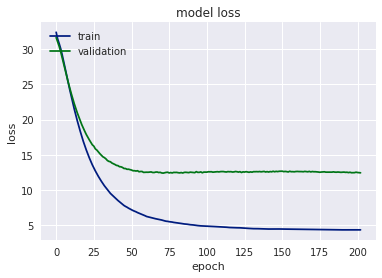

In [300]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

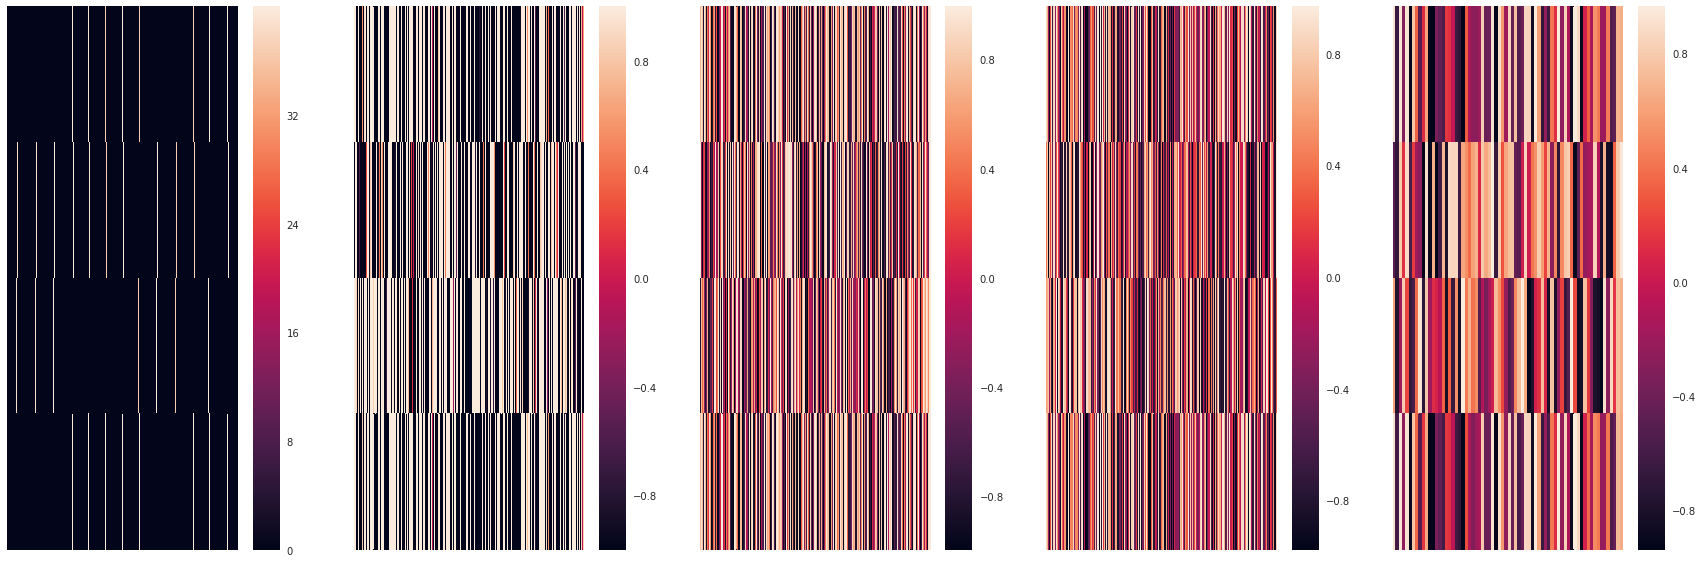

In [301]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

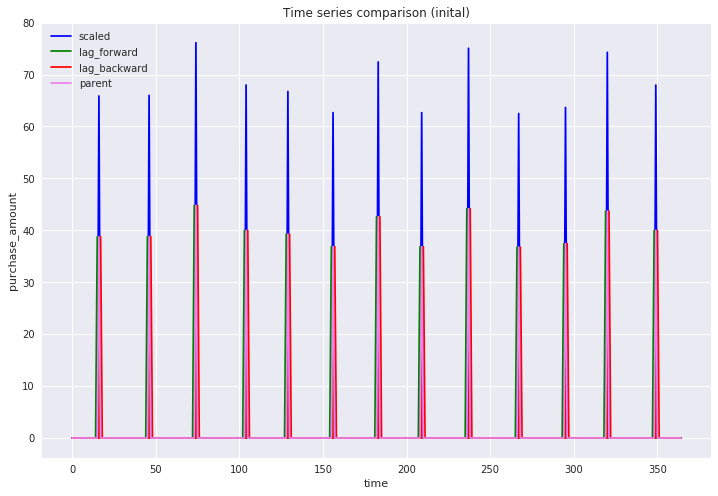

In [302]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [303]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


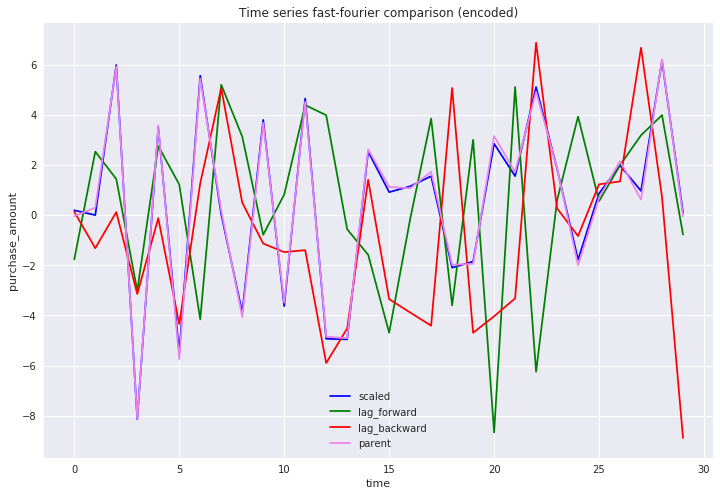

In [304]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [305]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,-0.715156,-0.171076,-0.498679,0.766542,0.113241,-0.940178,0.830572,-0.028134,0.935033,0.937875,-0.299788,-0.808531,0.737989,0.325838,0.862427,0.779441,0.606499,-0.015417,-0.270708,-0.096720,0.938634,0.281375,-0.407669,-0.719130,0.767869,-0.863241,0.456291,0.629365,-0.216195,-0.805992,-0.455597,0.011357,0.711806,0.904269,-0.718049,0.911280,-0.385836,-0.910891,-0.460863,-0.907982,-0.095905,0.451242,-0.106172,0.966601,0.940605,-0.331520,0.437818,0.809705,0.328548,0.533978,-0.617388,0.252348,0.579342,-0.221214,-0.087536,0.104032,-0.415186,0.342005,0.805539,-0.437789,0.458928,0.897743,-0.419093,-0.181714,-0.646837,-0.905739,0.832961,-0.710242,-0.255503,-0.860389
Donor_100,-0.029821,-0.199568,-0.004987,0.832150,0.519973,0.178071,-0.614670,-0.610283,-0.387959,0.666762,0.308177,-0.712739,-0.923182,0.735607,0.172652,-0.537276,0.591880,0.174324,-0.679090,-0.083808,0.446794,-0.393430,-0.952986,-0.240573,0.766796,-0.169362,0.621483,0.838463,-0.355935,-0.882210,0.643842,0.952081,0.838518,-0.233604,0.320506,-0.933785,-0.345465,0.815112,-0.885323,0.398159,-0.949970,0.851041,0.819934,-0.954788,0.442090,-0.327016,-0.827654,0.294338,0.109246,-0.711055,-0.781551,0.910453,-0.847612,-0.868534,0.051840,0.452677,-0.905719,0.210633,-0.223819,-0.532118,0.082477,0.914927,0.659753,-0.755684,0.905207,-0.443429,0.364879,-0.336325,-0.847502,0.008660
Donor_1000,-0.879969,-0.087811,0.872927,0.136257,-0.174062,-0.811128,0.031659,-0.245133,0.351710,0.827278,0.804386,-0.897427,0.952101,0.095782,0.590133,0.096891,-0.838525,-0.006966,-0.759188,-0.052360,-0.915835,0.942761,-0.769679,-0.527052,-0.751726,0.429171,0.710074,0.623928,0.669219,-0.693361,0.830059,-0.733815,-0.047445,0.112045,-0.151103,0.988280,-0.887225,-0.091196,-0.716065,0.401088,0.008122,-0.845831,0.782726,-0.297658,0.969090,0.666383,-0.180816,0.576172,-0.510303,0.334256,-0.703233,0.568488,0.808010,0.556749,-0.123006,0.870768,-0.385462,0.503207,0.057668,0.964322,-0.007079,0.230123,-0.527351,-0.711833,0.520437,-0.772045,0.296524,0.891767,-0.992174,0.659344
Donor_1001,-0.255737,-0.871709,-0.872424,-0.760789,0.275328,0.741703,0.781066,-0.143545,0.801443,-0.543927,-0.957411,-0.824987,-0.324353,0.787687,-0.934386,0.492628,-0.441478,0.249016,-0.308334,0.909710,-0.609614,-0.721858,-0.849341,-0.117281,-0.372310,-0.892498,0.989034,0.265648,-0.391046,-0.485470,0.806761,-0.197998,-0.307366,-0.892829,0.159995,-0.369065,0.726703,0.050891,-0.759107,-0.162930,0.599851,0.069164,0.910722,0.181583,-0.837640,0.711645,0.976459,0.568569,0.470294,-0.669002,-0.883179,-0.567905,0.537805,-0.654880,0.275876,-0.854026,-0.164077,0.802725,-0.230309,-0.782908,0.902701,-0.185657,0.185204,-0.395166,0.140936,0.831075,-0.277253,-0.555019,-0.566106,-0.197884
Donor_1002,0.910021,-0.803744,0.661129,-0.064592,0.063870,0.292375,-0.147225,0.893187,-0.191994,-0.761975,-0.486485,0.547489,0.867258,0.563602,-0.209407,-0.188118,-0.230374,0.969846,0.851748,0.944092,0.948405,0.277784,-0.854077,-0.598873,0.822779,0.979287,0.044356,0.118897,0.510350,-0.737010,0.118661,-0.790828,-0.858074,-0.836895,0.874198,-0.825647,-0.891548,0.379993,0.847407,-0.072776,0.515969,-0.783814,0.704618,-0.974055,0.782068,-0.901631,-0.335955,0.968665,-0.910042,-0.613517,-0.929018,0.291289,-0.096006,0.194282,0.554028,-0.907928,0.127834,-0.589023,-0.055163,0.056449,-0.594227,0.909350,0.426460,0.512113,0.771943,0.461888,-0.777543,-0.570423,-0.592494,0.013786


In [306]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,-0.969501,-0.742870,-0.539482,-0.348987,-0.723724,-0.224043,-0.184710,-0.199575,-0.784064,-0.324514,-0.647326,0.079578,-0.487284,0.926300,-0.373164,0.392551,0.087329,-0.813736,0.868118,0.615922,0.895323,0.900418,-0.714906,0.261814,-0.293343,-0.521836,0.611251,-0.633043,-0.931494,-0.986496,-0.795641,-0.267472,0.286936,-0.919375,-0.667884,-0.581970,0.282750,-0.157969,-0.512548,-0.689036,-0.979225,0.294993,0.917741,0.597686,0.978884,-0.721083,-0.348698,0.112011,0.241006,-0.758979,0.936594,-0.550337,0.851113,-0.728269,-0.009924,0.406527,0.102121,-0.527642,-0.917412,-0.699211,-0.750335,-0.483258,-0.739803,0.114323,-0.428927,0.178426,-0.011536,0.573838,0.852297,-0.041532
Test_145,-0.097516,-0.428398,-0.743271,-0.527092,-0.961582,0.978843,-0.059507,-0.067206,-0.221319,-0.606866,-0.644742,0.233898,-0.912495,-0.332053,-0.994843,-0.334182,-0.520561,0.908782,-0.113046,0.317093,-0.607029,-0.876938,-0.455915,-0.298206,-0.662220,0.721955,-0.246873,0.236300,-0.221404,-0.938958,0.899937,0.732148,0.325446,-0.221834,-0.215123,-0.605141,-0.237380,0.136836,0.367070,-0.444727,-0.698106,0.421602,0.564050,-0.977239,-0.942382,-0.444733,0.876046,-0.701269,-0.565363,-0.689735,0.036328,0.210828,-0.942890,0.143653,-0.130730,0.019167,-0.726584,0.702912,-0.977007,-0.502990,-0.134937,-0.314869,0.984802,-0.018510,-0.334052,0.348838,0.485992,-0.614998,-0.370124,0.075228
Test_1450,0.983699,-0.925807,0.871775,-0.498103,-0.406014,-0.827988,-0.045534,-0.705123,-0.257816,0.013729,0.937088,0.304758,-0.107770,-0.283779,-0.696236,-0.165690,-0.324000,0.084927,-0.231503,0.761873,-0.676291,0.613801,0.215046,0.037905,0.664778,0.543889,0.541440,0.596676,0.430702,0.504000,0.819839,-0.947627,0.639430,0.135348,-0.537000,-0.349094,-0.343612,0.692622,0.256439,-0.873672,0.439232,0.272480,-0.634552,-0.467795,0.788565,0.757096,-0.082110,0.928392,-0.594371,-0.604701,-0.791595,0.784564,-0.168467,0.241440,-0.149766,-0.984498,-0.815009,0.720009,-0.859079,-0.372508,0.815183,0.159630,-0.715874,0.125855,-0.393424,-0.097833,0.367884,-0.818359,0.940855,0.752070
Test_1451,-0.879554,-0.937525,0.819346,-0.420604,0.891402,0.834143,-0.388683,0.910147,-0.583249,-0.472499,0.966938,0.790821,-0.861527,0.763703,-0.088442,0.423877,-0.410348,-0.137037,0.968642,-0.179788,0.869668,-0.969247,-0.648768,-0.865912,0.626752,0.767729,-0.451241,-0.635500,0.523516,0.806350,0.443721,-0.897773,0.324946,0.330516,-0.205404,0.115141,0.391318,0.413190,0.212584,-0.425593,-0.403521,0.674509,-0.331395,-0.363679,0.187917,-0.566624,0.764445,0.935971,-0.431318,-0.453885,-0.420859,0.793247,0.408103,0.429157,0.688746,-0.985170,-0.434918,-0.314315,-0.945564,-0.196785,0.732284,-0.102679,-0.391588,0.885687,0.913294,-0.616912,-0.081667,0.817328,0.785164,0.413060
Test_1452,-0.920093,-0.313234,-0.090186,-0.529225,0.205563,0.760238,0.900160,0.908242,0.763077,-0.297428,-0.413975,0.048860,-0.101480,0.276743,0.372284,0.086370,-0.921084,0.635372,-0.399484,0.502756,-0.286914,-0.915793,0.216131,-0.916112,-0.320573,-0.281559,0.012004,-0.340065,0.789292,-0.033369,-0.662438,-0.979523,0.058123,0.720442,0.888687,0.052022,-0.216356,0.205479,0.107409,-0.534428,0.677100,0.897916,-0.330411,0.689905,0.092463,-0.862422,0.959484,-0.444605,-0.568479,0.338434,0.452790,-0.721713,0.708286,0.729115,0.819612,0.452153,0.656128,0.668365,-0.664538,0.923505,-0.931190,-0.838453,0.489139,0.258554,-0.599245,0.963735,0.410913,-0.200275,-0.478932,0.876982


In [307]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [308]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.000000,25.646683,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,28.184626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,32.70784,0.000000,0.0,0.000000,3.828148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.512032,0.0,24.632477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,22.518045,0.0,2.90134,0.000000,0.0,0.287536,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.424316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2.552944,0.0,0.0,0.0,0.00000,30.455254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.833279,0.0,0.0,0.000000,0.0,0.0,34.900608,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.931368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.544355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.736892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.851170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,37.930683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,19.498529,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,17.007042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0

In [309]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,34.0962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,27.922484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.689643,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,32.538395,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,31.536311,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31.296507,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,32.473824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,25.174308,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,27.997594,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,32.697277,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,33.582588,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.953825,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.773184,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.259073
Test_145,0.0,0.0,43.088934,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.384996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,40.449101,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.

In [310]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,37.192711,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,18.441774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,24.745356,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,58.449005,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,15.504677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,52.274002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,12.198013,0.000000,3.130644,0.0,0.0,0.0,8.582911,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,11.288418,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,25.212524,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.744683,0.000000,0.00000,0.0,0.000000,0.000000,39.983242,0.0,0.0,0.0,0.992543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,4.009601,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,54.765423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,47.796219
Test_145,0.0,0.0,10.719724,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.251975,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.478626,0.000000,0.0,0.0,0.0,

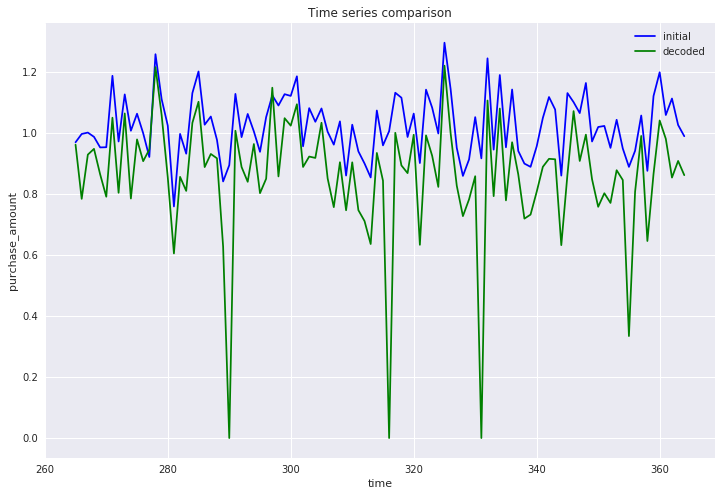

In [311]:
plt.figure(figsize = (12,8))
plt.plot(average_initial[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


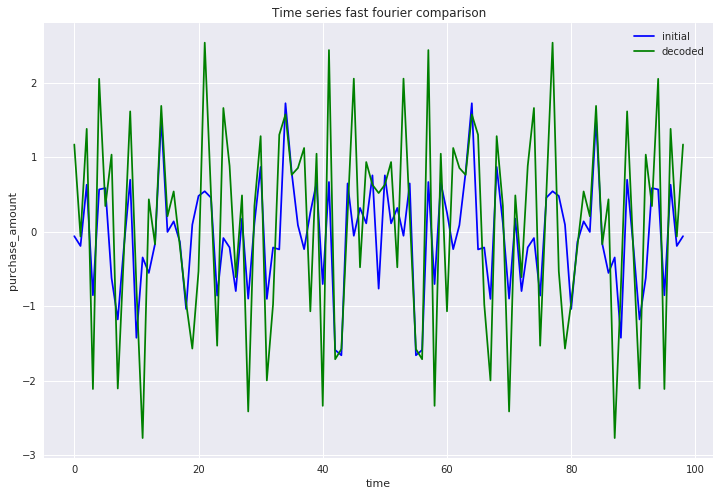

In [312]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

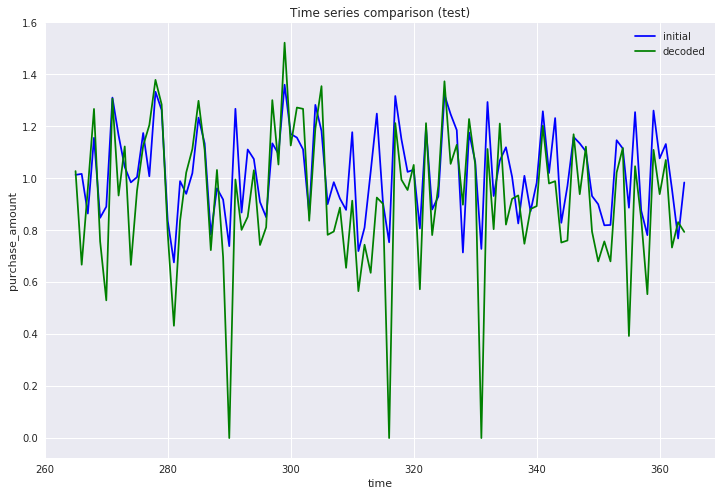

In [313]:
plt.figure(figsize = (12,8))
plt.plot(average_initial_test[-100:], color = 'blue', label = 'initial')
plt.plot(average_decoded_test[-100:], color = 'green', label = 'decoded')
plt.title('Time series comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


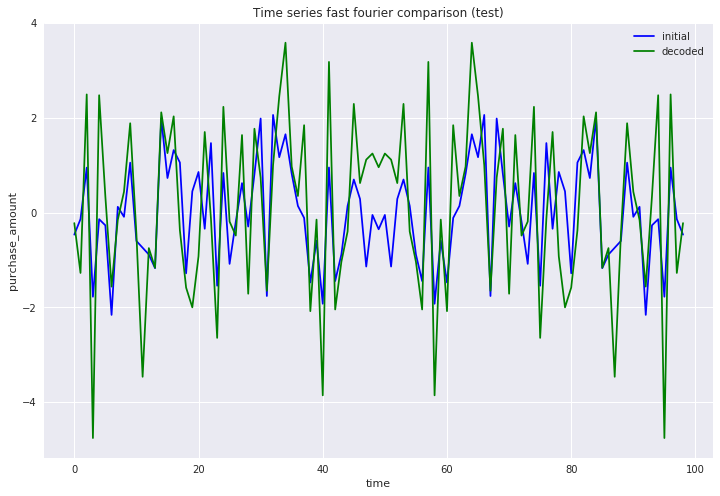

In [314]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(average_initial_test[-100:])[1:], color = 'blue', label = 'initial')
plt.plot(np.fft.fft(average_decoded_test[-100:])[1:], color = 'green', label = 'decoded')
plt.title('Time series fast fourier comparison (test)')
plt.legend()
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [315]:
binary_xtrain = np.where(xtrain>0, 1, 0)
binary_decoded_mat = np.where(decoded_mat>0,1,0)

binary_xtest = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = np.where(decoded_mat_test>0,1,0)

In [316]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtrain)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(binary_xtrain), np.linalg.norm(binary_decoded_mat))))

Percent similarity 92.59585383945233
Percent similarity binary 98.15415504913045


In [317]:
print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(binary_xtest)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(binary_xtest), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity 96.4860763525379
Percent similarity binary 88.00167315463601


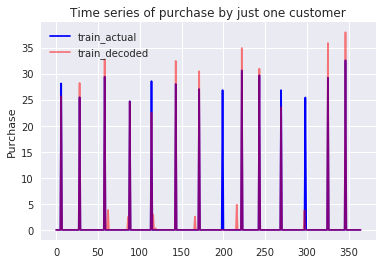

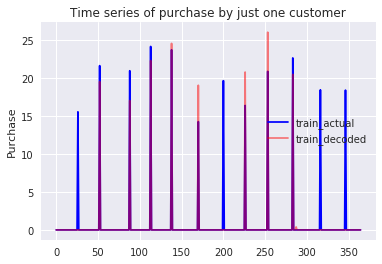

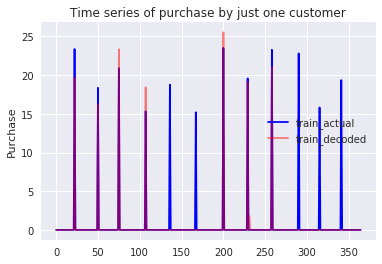

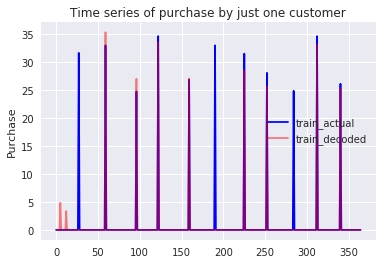

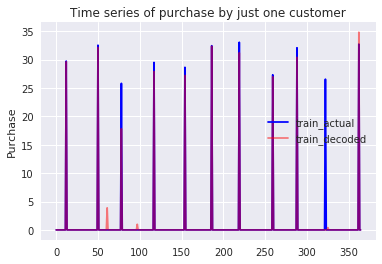

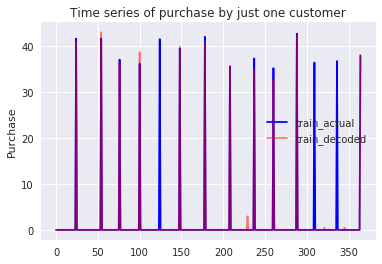

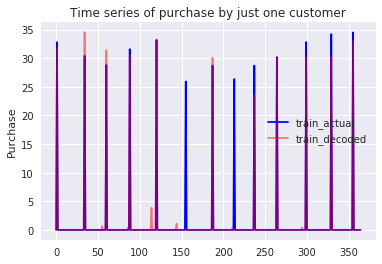

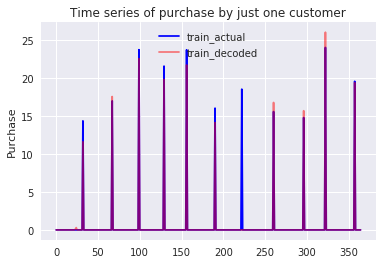

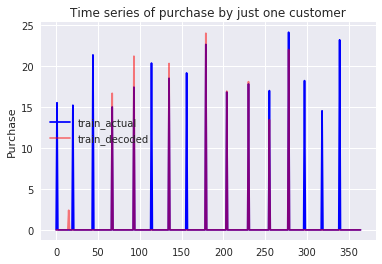

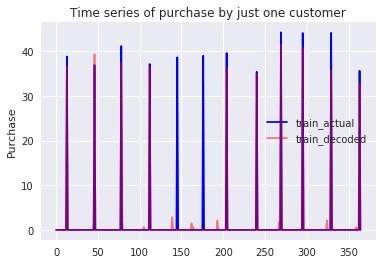

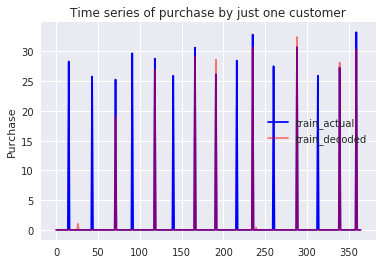

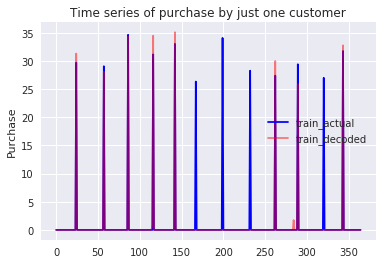

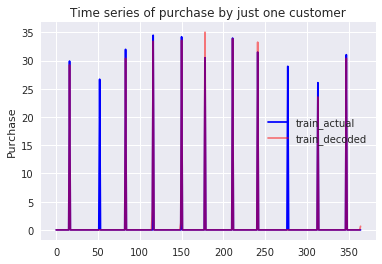

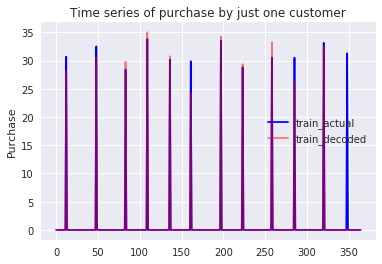

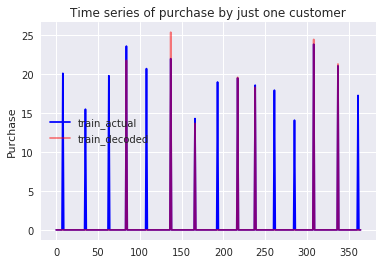

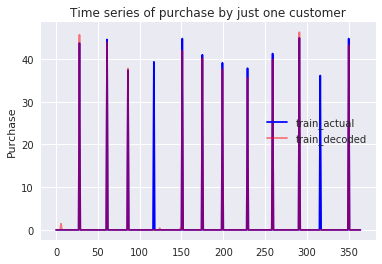

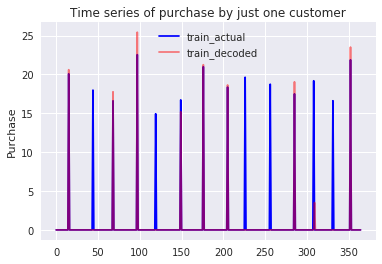

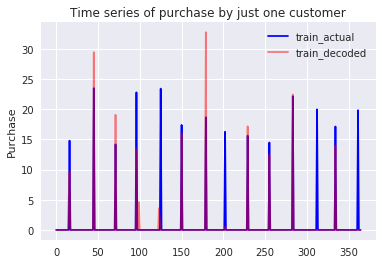

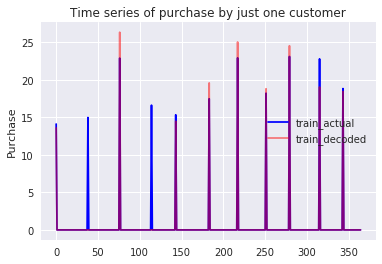

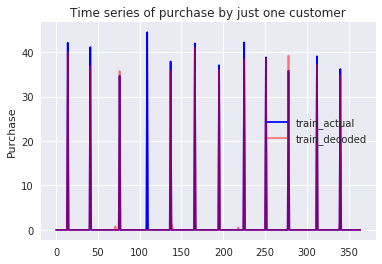

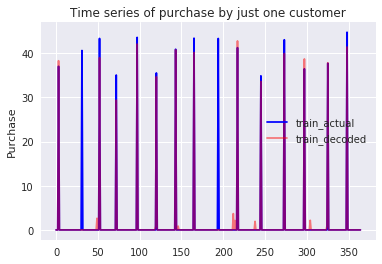

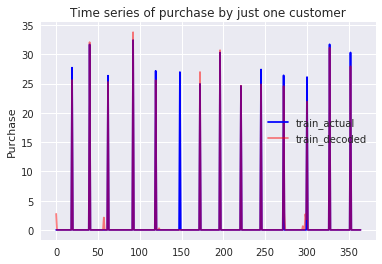

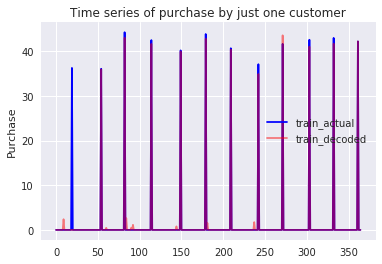

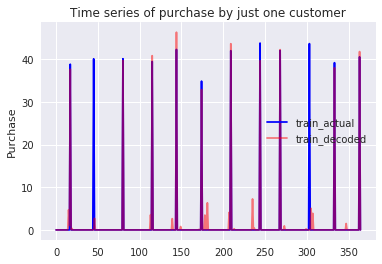

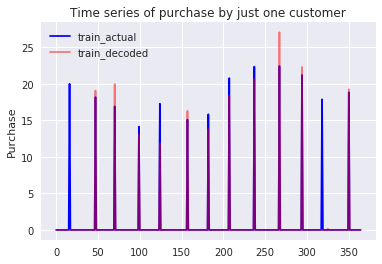

In [318]:
for i in list(xtrain.index[:25]):
    plt.title('Time series of purchase by just one customer')
    plt.plot(xtrain.loc[i,:], color = 'blue', label = 'train_actual')
    plt.plot(comparison.loc[i,:], color = 'red', label = 'train_decoded', alpha=0.5)
    plt.legend(loc='best')
    plt.ylabel('Purchase')
    plt.show()

In [319]:
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Donor_100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

In [320]:
xtrain.shape

(5000, 365)

In [321]:
selecting_test_pool = xtrain.T

In [322]:
recency = []
for i in selecting_test_pool.columns:
    recency.append(len(selecting_test_pool)-selecting_test_pool[i][selecting_test_pool[i]!=0].index[-1])

recency_df = pd.DataFrame(np.asarray(recency).reshape(1,5000), columns = selecting_test_pool.columns)
selecting_test_pool = pd.concat([recency_df, selecting_test_pool]).reset_index(drop = True)
select_trans = selecting_test_pool.T
select_trans = select_trans.rename(columns = {0:'recency'})

select_trans['frequency'] = select_trans.gt(0).sum(axis=1) - 1

In [323]:
select_trans['monetary'] = select_trans.sum(axis = 1)

In [324]:
select_trans.head()

,recency,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,frequency,monetary
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,19.0,0.0,0.0,0.0,0.0,0.0,0.0,28.103086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,25.465567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,29.395883,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.681370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,28.54345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,28.002926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,27.025801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.822557,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,30.611507,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.675734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.815237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.406283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.19701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,32.555135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,14,425.301546
Donor_100,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,15.523447,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.602001,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.930828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

In [325]:
rfm_df = select_trans[['recency', 'monetary', 'frequency']]

In [326]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in rfm_df.columns:
    rfm_df[i] = scaler.fit_transform(np.asarray(rfm_df[i]).reshape(-1,1))

/home/fractaluser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/fractaluser/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [327]:
import scipy.stats  as st

In [328]:
moe = .05
cl= .95
n_sample = int(st.norm.ppf(cl+(1-cl)/2)**2/(moe**2))
print(n_sample)

1536


In [329]:
epochs = 1000000
for i in range(epochs):
    sample = rfm_df.sample(n_sample)
    com_sample = rfm_df[~rfm_df.index.isin(sample.index)]
    a = st.ttest_ind(sample.recency, com_sample.recency, equal_var = True)
    b = st.ttest_ind(sample.frequency, com_sample.frequency, equal_var = True)
    c = st.ttest_ind(sample.monetary, com_sample.monetary, equal_var = True)
    if a[1]>=.95 and b[1]>=.95 and c[1]>=.95:
        break